[*********************100%***********************]  14 of 14 completed


Datos descargados:
Ticker           AAPL       AMZN         BLK         F      GOOGL         HII  \
Date                                                                            
2019-11-29  64.702400  90.040001  431.485291  7.030434  64.894241  223.090698   
2019-12-02  63.954300  89.080002  426.942993  6.991636  64.136368  221.645813   
2019-12-03  62.814003  88.498001  423.507904  6.898518  64.428963  220.918915   
2019-12-04  63.368435  88.034500  424.318665  6.945076  65.633209  225.599319   
2019-12-05  64.298088  87.024002  430.384308  6.929556  66.032303  223.409805   

Ticker             JPM       KTOS         LMT        MSFT        NKE  \
Date                                                                   
2019-11-29  113.444168  18.059999  339.589874  144.503052  87.820206   
2019-12-02  113.194496  17.700001  333.154602  142.756149  87.885956   
2019-12-03  111.739426  17.200001  331.417633  142.527039  86.852646   
2019-12-04  113.943550  17.160000  333.988373  143.04

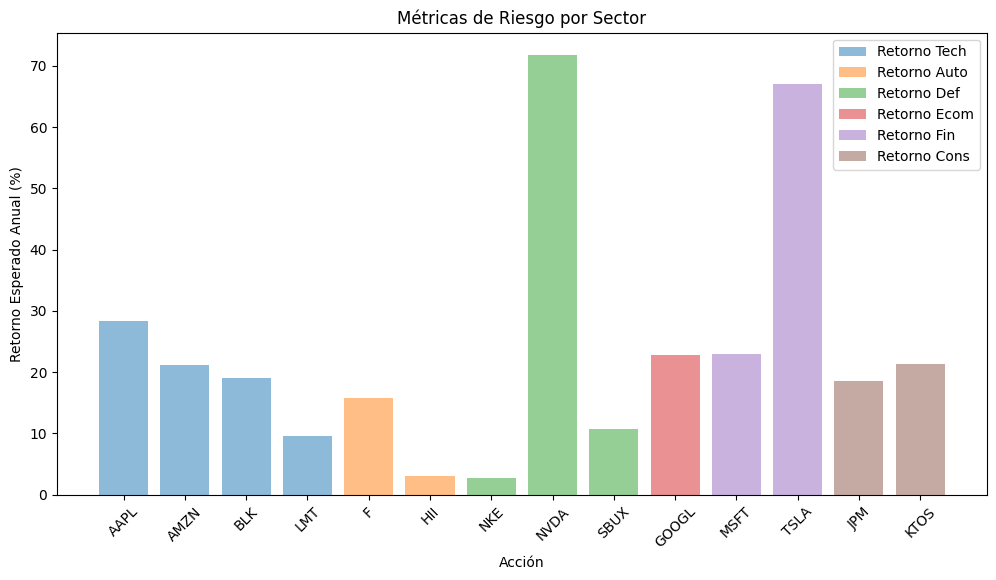


Cuestionario de Perfil de Riesgo (Simulado):
1. ¿Cuál es su horizonte de inversión? (1: Corto plazo, 2: Mediano plazo, 3: Largo plazo)
2. ¿Qué nivel de pérdida está dispuesto a tolerar? (1: <5%, 2: 5-10%, 3: >10%)
Perfil de Riesgo del Cliente: Agresivo


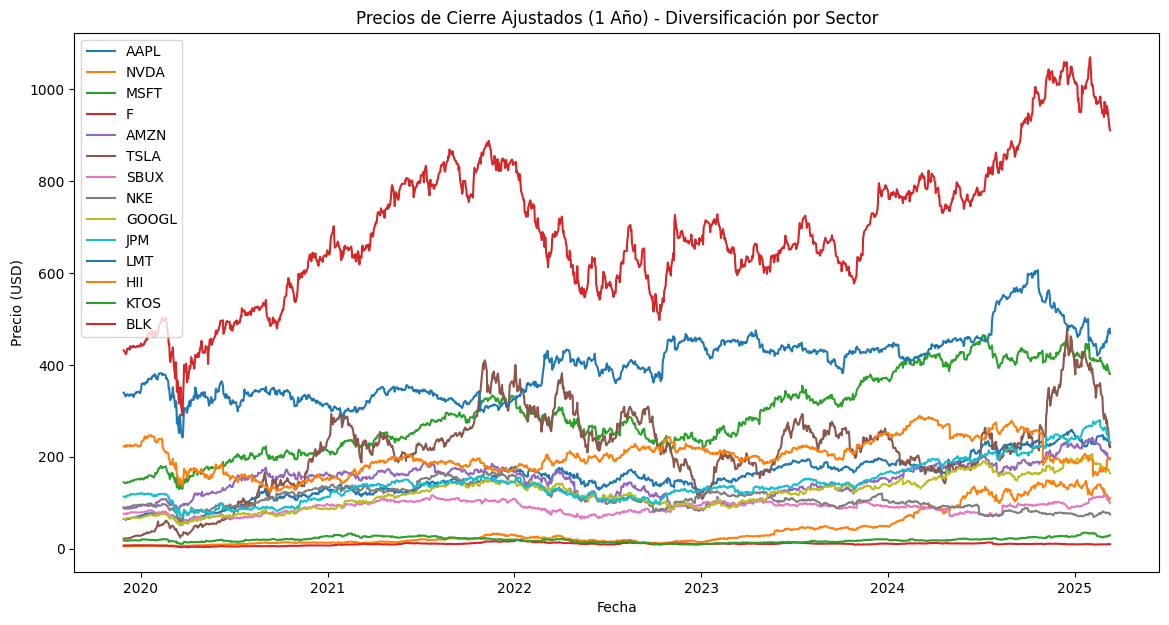

[*********************100%***********************]  1 of 1 completed



Bondad de Ajuste (R²) para el modelo de AAPL: 0.1273


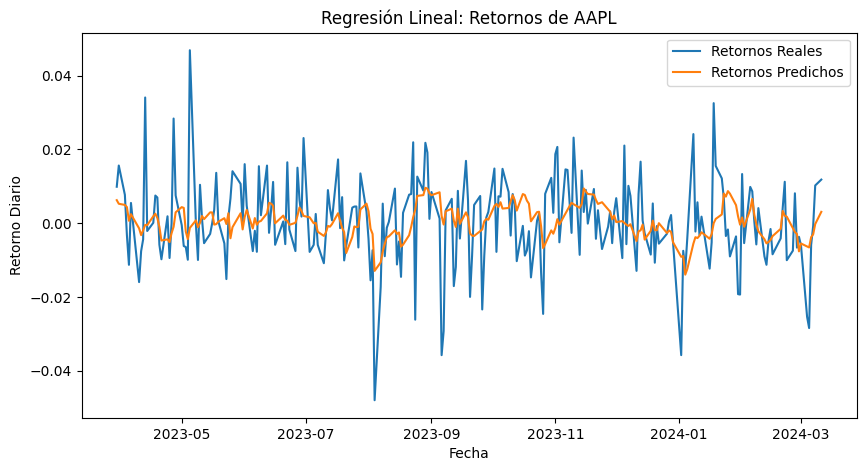

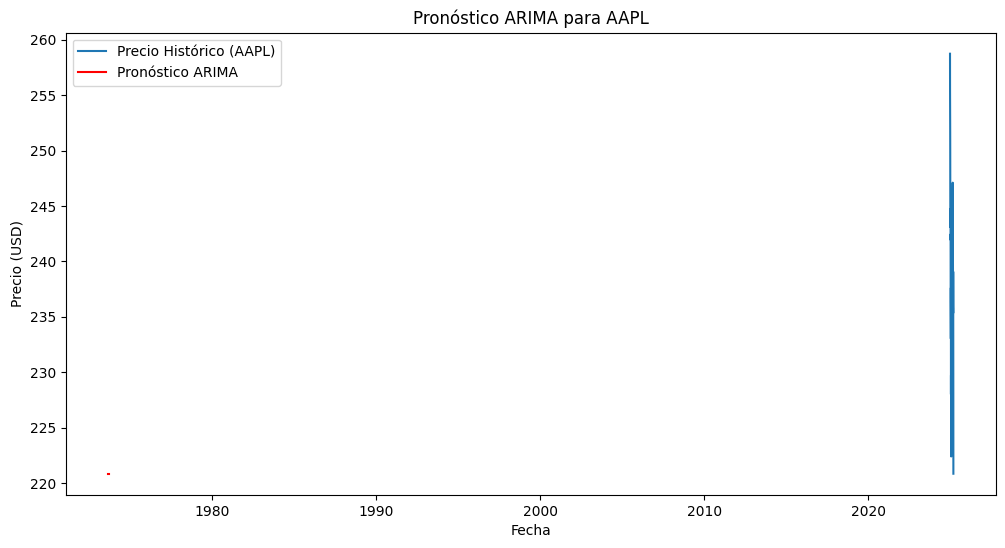

In [ ]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

# Definir las 14 acciones estadounidenses (incluyendo diversificación)
tickers = ['AAPL', 'NVDA', 'MSFT', 'F', 'AMZN', 'TSLA', 'SBUX', 'NKE', 'GOOGL', 'JPM', 'LMT', 'HII', 'KTOS', 'BLK']

# Descargar datos de yfinance (1 año de datos diarios)
data = yf.download(tickers, start='2019-11-29', end='2025-03-12', interval='1d')['Close']
print("Datos descargados:")
print(data.head())

# Calcular retornos diarios
returns = data.pct_change().dropna()
print("\nRetornos diarios:")
print(returns.head())

# --- Métricas de Riesgo ---
# Calcular retorno esperado (media) y riesgo (desviación estándar)
mean_returns = returns.mean() * 252  # Anualizado
std_dev = returns.std() * np.sqrt(252)  # Anualizado

# Calcular VaR (Value at Risk) al 95%
var_95 = returns.quantile(0.05)

# Mostrar métricas de riesgo
risk_metrics = pd.DataFrame({
    'Retorno Esperado Anual (%)': mean_returns * 100,
    'Riesgo Anual (%)': std_dev * 100,
    'VaR 95% (Diario)': var_95
})
print("\nMétricas de Riesgo:")
print(risk_metrics)

# Visualizar métricas de riesgo por sector
sectors = ['Tech', 'Tech', 'Tech', 'Auto', 'Ecom', 'Auto', 'Cons', 'Cons', 'Tech', 'Fin', 'Def', 'Def', 'Def', 'Fin']
risk_metrics['Sector'] = sectors
plt.figure(figsize=(12, 6))
for sector in set(sectors):
    sector_data = risk_metrics[risk_metrics['Sector'] == sector]
    plt.bar(sector_data.index, sector_data['Retorno Esperado Anual (%)'], label=f'Retorno {sector}', alpha=0.5)
plt.title('Métricas de Riesgo por Sector')
plt.xlabel('Acción')
plt.ylabel('Retorno Esperado Anual (%)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# --- Perfil de Riesgo del Cliente (Simulado) ---
def assess_risk_profile():
    print("\nCuestionario de Perfil de Riesgo (Simulado):")
    print("1. ¿Cuál es su horizonte de inversión? (1: Corto plazo, 2: Mediano plazo, 3: Largo plazo)")
    print("2. ¿Qué nivel de pérdida está dispuesto a tolerar? (1: <5%, 2: 5-10%, 3: >10%)")
    score = 2 + 3  # Ejemplo: horizonte largo plazo y tolerancia alta
    if score >= 5:
        return "Agresivo"
    elif score >= 3:
        return "Moderado"
    else:
        return "Conservador"

risk_profile = assess_risk_profile()
print(f"Perfil de Riesgo del Cliente: {risk_profile}")

# --- Visualización de Precios ---
plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(data.index, data[ticker], label=ticker)
plt.title('Precios de Cierre Ajustados (1 Año) - Diversificación por Sector')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.show()

# --- Entregable A: Identificación de Variables y Modelado ---
# Ejemplo con AAPL: Variables dependientes e independientes
data_full = yf.download('AAPL', start='2023-03-12', end='2024-03-12', interval='1d')
data_full['Returns'] = data_full['Close'].pct_change()

# Indicadores Técnicos
exp1 = data_full['Close'].ewm(span=12, adjust=False).mean()
exp2 = data_full['Close'].ewm(span=26, adjust=False).mean()
data_full['MACD'] = exp1 - exp2
data_full['Signal Line'] = data_full['MACD'].ewm(span=9, adjust=False).mean()

delta = data_full['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data_full['RSI'] = 100 - (100 / (1 + rs))

# Regresión Lineal
features = data_full[['MACD', 'RSI', 'Volume']].dropna()
target = data_full['Returns'].loc[features.index]
model = LinearRegression()
model.fit(features, target)
predictions = model.predict(features)
r2 = r2_score(target, predictions)
print(f"\nBondad de Ajuste (R²) para el modelo de AAPL: {r2:.4f}")

# Visualización de regresión
plt.figure(figsize=(10, 5))
plt.plot(target.index, target, label='Retornos Reales')
plt.plot(target.index, predictions, label='Retornos Predichos')
plt.title('Regresión Lineal: Retornos de AAPL')
plt.xlabel('Fecha')
plt.ylabel('Retorno Diario')
plt.legend()
plt.show()

# --- Pronósticos con ARIMA ---
arima_model = ARIMA(data['AAPL'], order=(0, 1, 0))
arima_fit = arima_model.fit()
forecast = arima_fit.forecast(steps=30)
plt.figure(figsize=(12, 6))
plt.plot(data['AAPL'].tail(50), label='Precio Histórico (AAPL)')
plt.plot(forecast.index, forecast, label='Pronóstico ARIMA', color='red')
plt.title('Pronóstico ARIMA para AAPL')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.show()

In [ ]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

# Definir las 14 acciones estadounidenses
tickers = ['AAPL', 'NVDA', 'MSFT', 'F', 'AMZN', 'TSLA', 'SBUX', 'NKE', 'GOOGL', 'JPM', 'LMT', 'HII', 'KTOS', 'BLK']

# Descargar datos de yfinance (1 año de datos diarios)
data = yf.download(tickers, start='2019-11-29', end='2025-03-12', interval='1d')['Close']
print("Datos descargados:")
print(data.head())

# Calcular retornos diarios
returns = data.pct_change().dropna()
print("\nRetornos diarios:")
print(returns.head())

# --- Métricas de Riesgo ---
mean_returns = returns.mean() * 252  # Anualizado
std_dev = returns.std() * np.sqrt(252)  # Anualizado
var_95 = returns.quantile(0.05)

risk_metrics = pd.DataFrame({
    'Retorno Esperado Anual (%)': mean_returns * 100,
    'Riesgo Anual (%)': std_dev * 100,
    'VaR 95% (Diario)': var_95
})
print("\nMétricas de Riesgo:")
print(risk_metrics)

# Visualizar métricas de riesgo por sector
sectors = ['Tech', 'Tech', 'Tech', 'Auto', 'Ecom', 'Auto', 'Cons', 'Cons', 'Tech', 'Fin', 'Def', 'Def', 'Def', 'Fin']
risk_metrics['Sector'] = sectors
plt.figure(figsize=(12, 6))
for sector in set(sectors):
    sector_data = risk_metrics[risk_metrics['Sector'] == sector]
    plt.bar(sector_data.index, sector_data['Retorno Esperado Anual (%)'], label=f'Retorno {sector}', alpha=0.5)
plt.title('Métricas de Riesgo por Sector')
plt.xlabel('Acción')
plt.ylabel('Retorno Esperado Anual (%)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# --- Perfil de Riesgo del Cliente ---
def assess_risk_profile():
    score = 2 + 3  # Ejemplo: horizonte largo plazo y tolerancia alta
    if score >= 5:
        return "Agresivo"
    elif score >= 3:
        return "Moderado"
    else:
        return "Conservador"
risk_profile = assess_risk_profile()
print(f"Perfil de Riesgo del Cliente: {risk_profile}")

# --- Visualización de Precios ---
plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(data.index, data[ticker], label=ticker)
plt.title('Precios de Cierre Ajustados (1 Año) - Diversificación por Sector')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.show()

# --- Regresión Lineal para Todas las Acciones ---
r2_scores = {}
for ticker in tickers:
    data_full = yf.download(ticker, start='2023-03-12', end='2024-03-12', interval='1d')
    data_full['Returns'] = data_full['Close'].pct_change()
    exp1 = data_full['Close'].ewm(span=12, adjust=False).mean()
    exp2 = data_full['Close'].ewm(span=26, adjust=False).mean()
    data_full['MACD'] = exp1 - exp2
    data_full['Signal Line'] = data_full['MACD'].ewm(span=9, adjust=False).mean()
    delta = data_full['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data_full['RSI'] = 100 - (100 / (1 + rs))
    features = data_full[['MACD', 'RSI', 'Volume']].dropna()
    target = data_full['Returns'].loc[features.index]
    if len(features) > 0 and len(target) > 0:
        model = LinearRegression()
        model.fit(features, target)
        predictions = model.predict(features)
        r2 = r2_score(target, predictions)
        r2_scores[ticker] = r2
        plt.figure(figsize=(10, 5))
        plt.plot(target.index, target, label='Retornos Reales')
        plt.plot(target.index, predictions, label='Retornos Predichos')
        plt.title(f'Regresión Lineal: Retornos de {ticker} (R² = {r2:.4f})')
        plt.xlabel('Fecha')
        plt.ylabel('Retorno Diario')
        plt.legend()
        plt.show()
print("\nR² Scores por Acción:")
for ticker, r2 in r2_scores.items():
    print(f"{ticker}: {r2:.4f}")

# --- Pronóstico ARIMA para Todas las Acciones ---
for ticker in tickers:
    arima_model = ARIMA(data[ticker], order=(0, 1, 0))
    arima_fit = arima_model.fit()
    forecast = arima_fit.forecast(steps=30)
    plt.figure(figsize=(12, 6))
    plt.plot(data[ticker].tail(50), label=f'Precio Histórico ({ticker})')
    plt.plot(forecast.index, forecast, label='Pronóstico ARIMA', color='red')
    plt.title(f'Pronóstico ARIMA para {ticker}')
    plt.xlabel('Fecha')
    plt.ylabel('Precio (USD)')
    plt.legend()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.


AAPL - ADF p-value: 0.5450, KPSS p-value: 0.0100


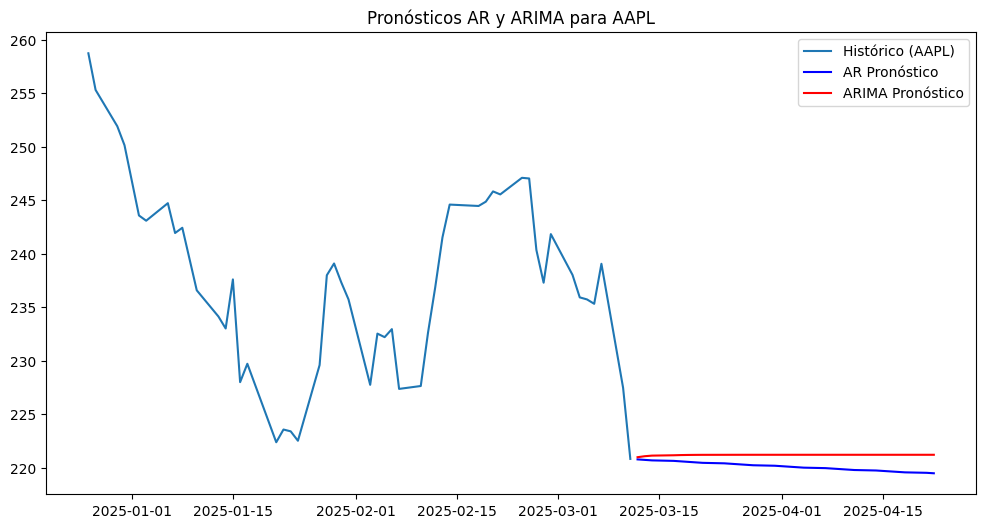


NVDA - ADF p-value: 0.9317, KPSS p-value: 0.0100


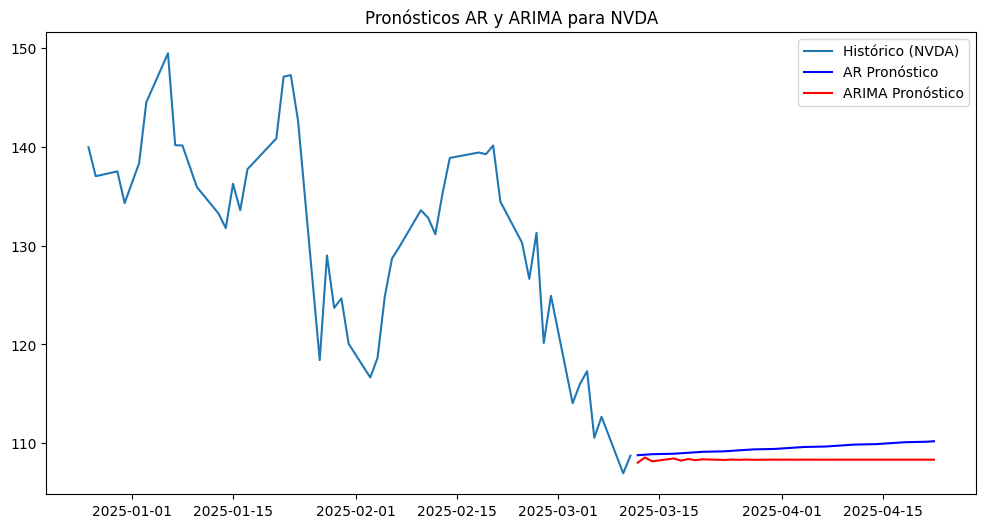


MSFT - ADF p-value: 0.5625, KPSS p-value: 0.0100


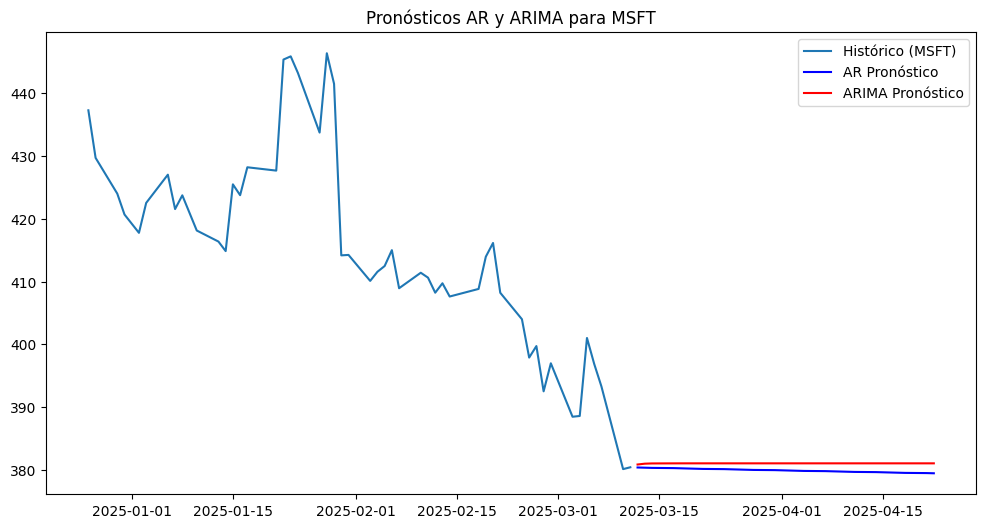


F - ADF p-value: 0.3091, KPSS p-value: 0.0100


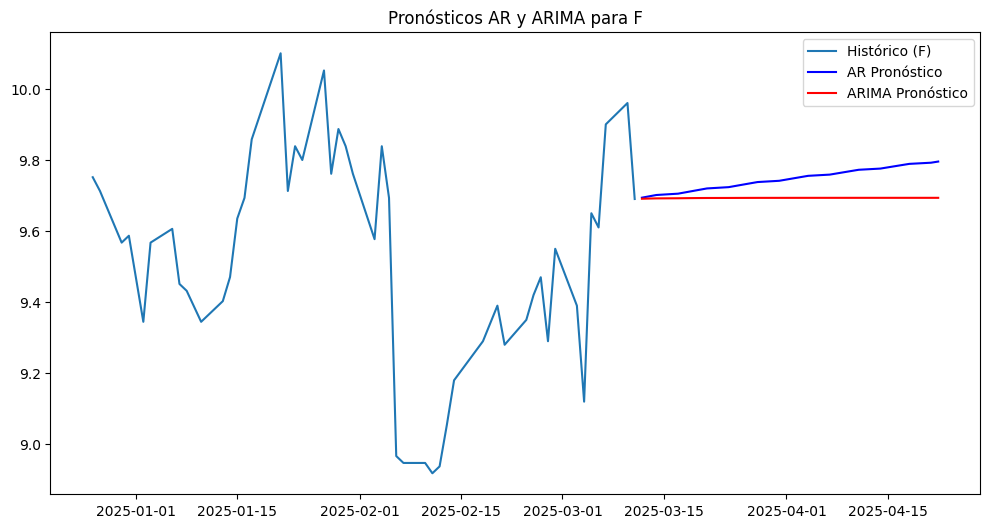


AMZN - ADF p-value: 0.3980, KPSS p-value: 0.0100


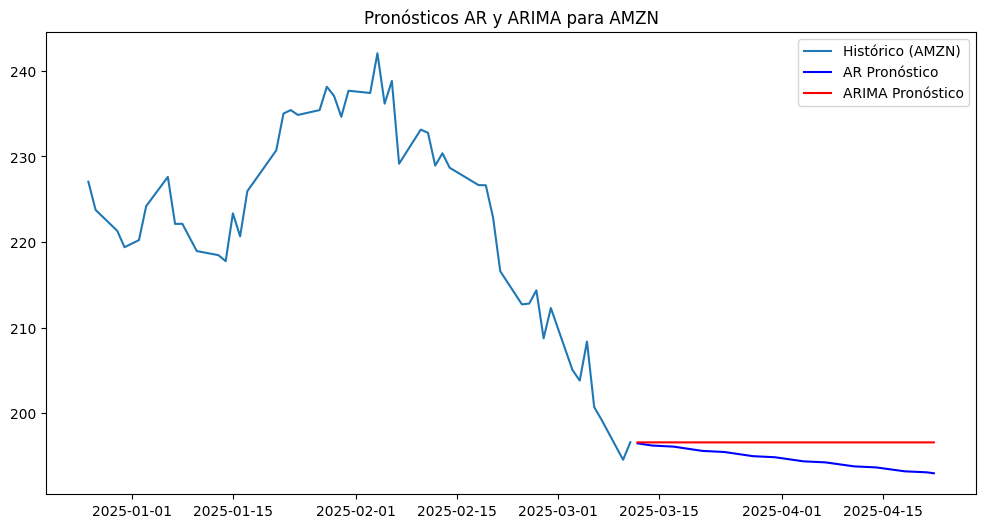


TSLA - ADF p-value: 0.0722, KPSS p-value: 0.0100


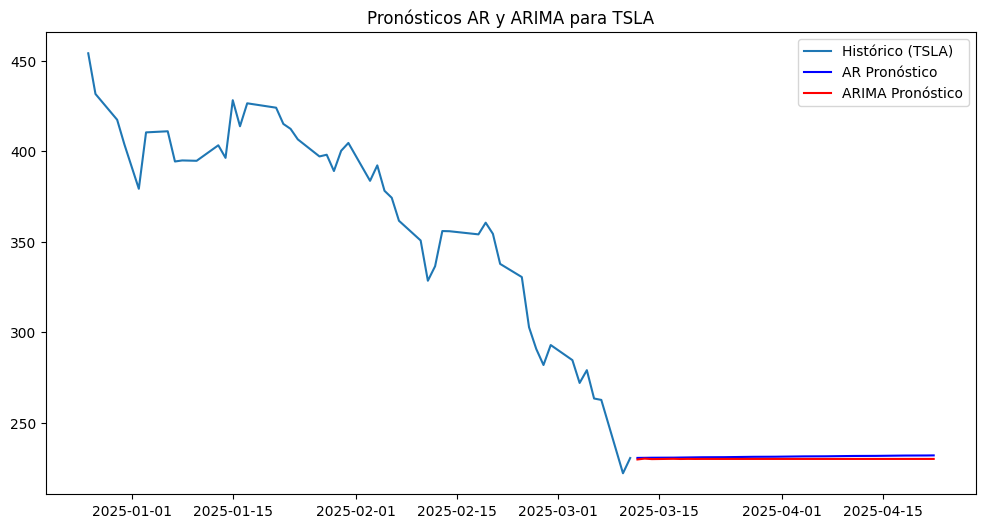


SBUX - ADF p-value: 0.2028, KPSS p-value: 0.0100


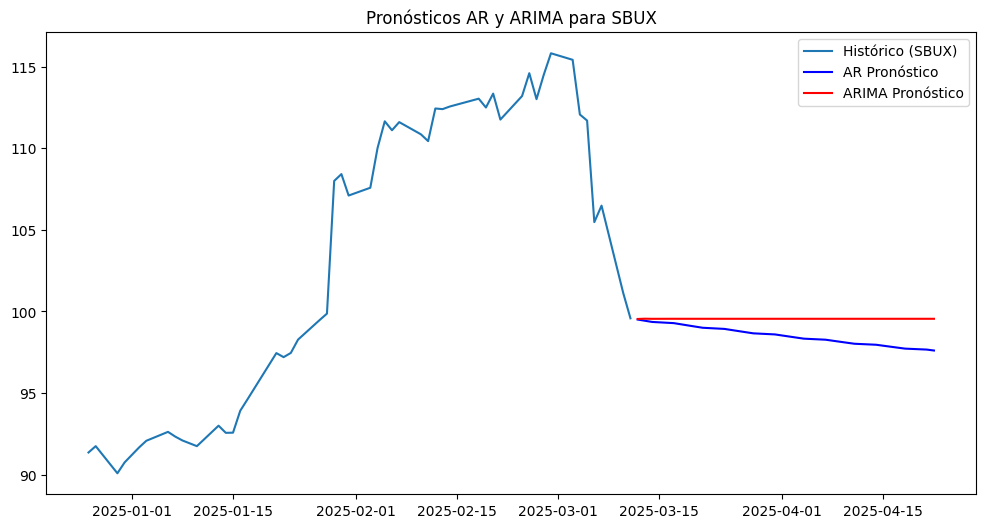


NKE - ADF p-value: 0.5296, KPSS p-value: 0.0100


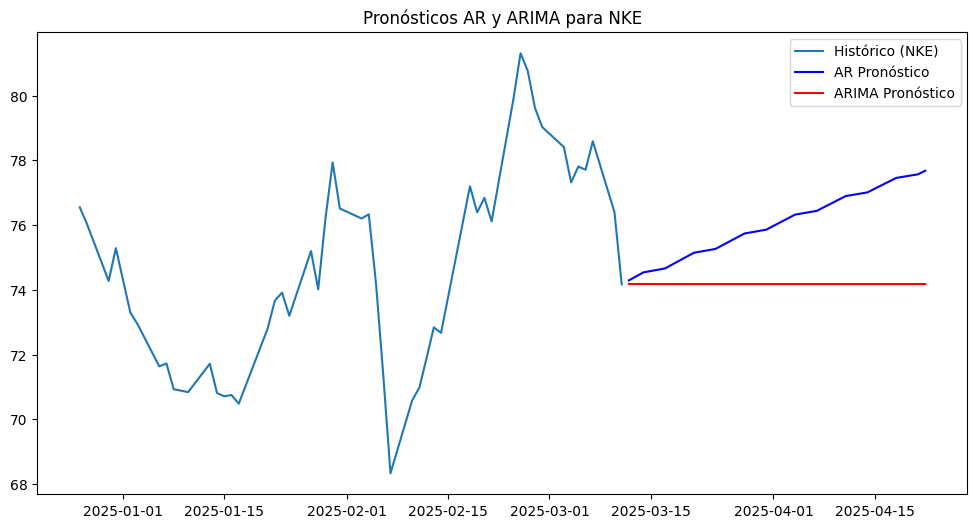


GOOGL - ADF p-value: 0.6184, KPSS p-value: 0.0100


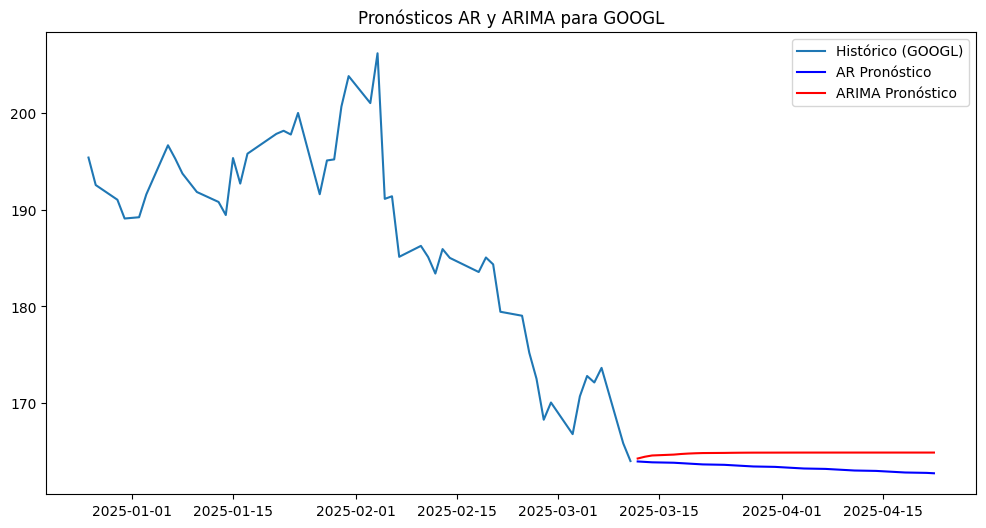


JPM - ADF p-value: 0.8950, KPSS p-value: 0.0100


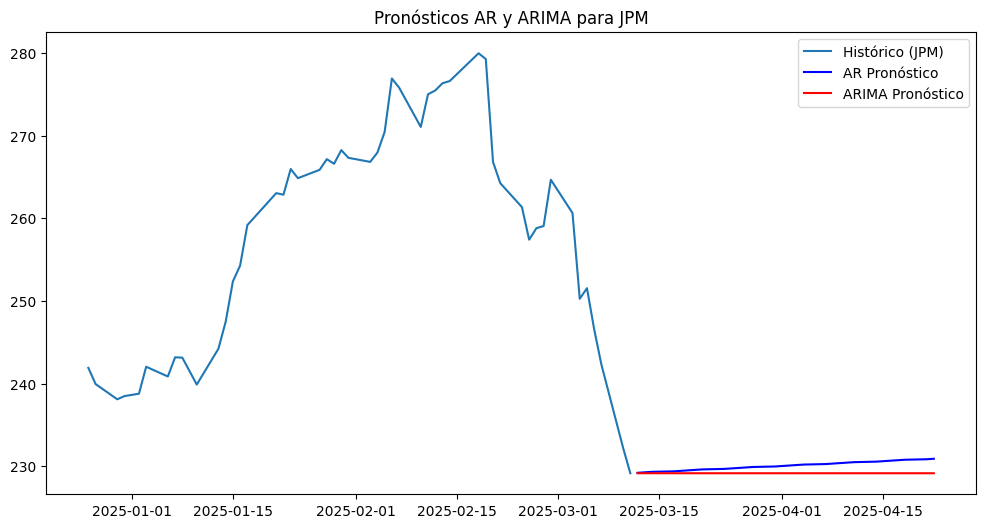


LMT - ADF p-value: 0.5171, KPSS p-value: 0.0100


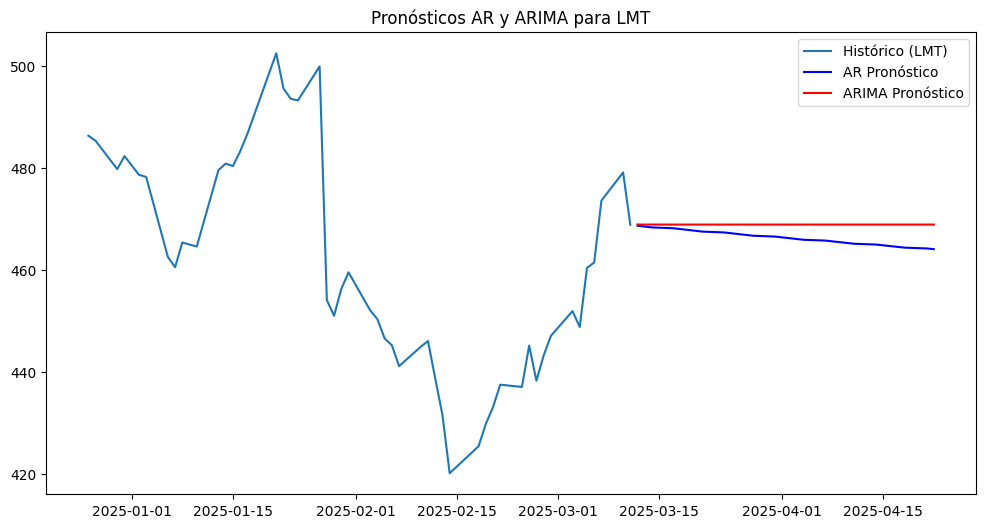


HII - ADF p-value: 0.2400, KPSS p-value: 0.0100


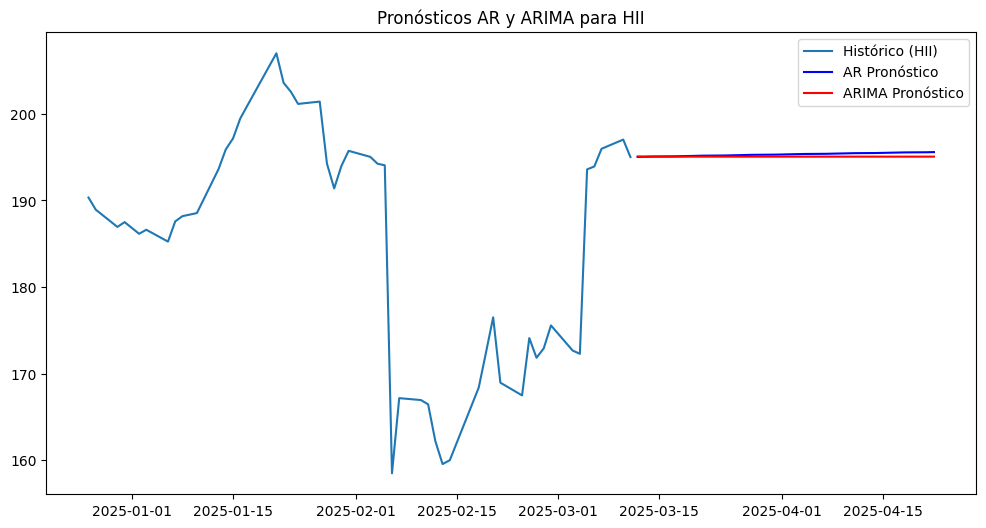


KTOS - ADF p-value: 0.4420, KPSS p-value: 0.0100


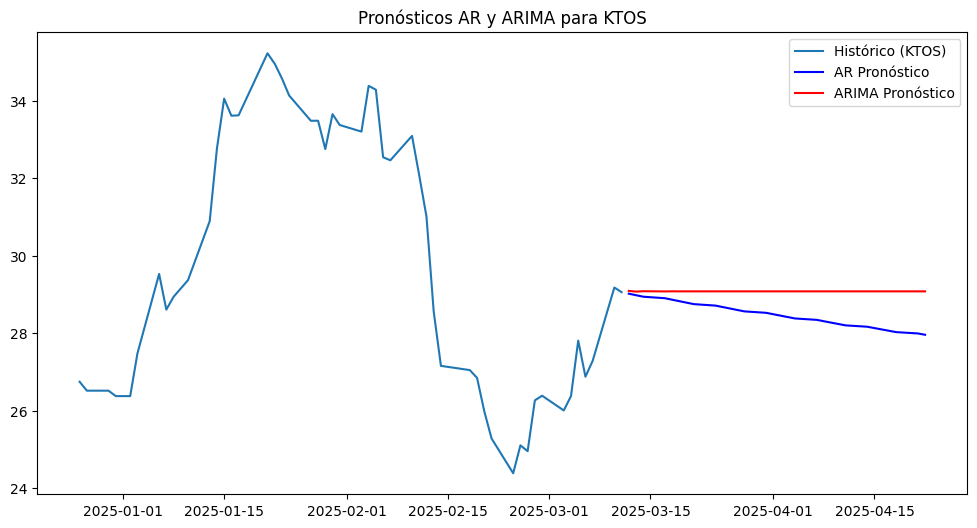


BLK - ADF p-value: 0.4805, KPSS p-value: 0.0100


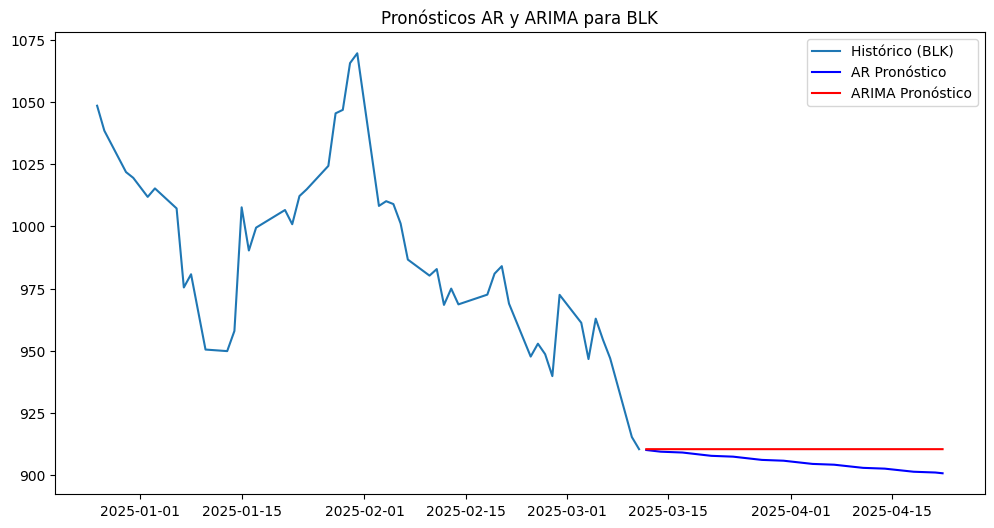

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss

for ticker in tickers[:14]:  # Limitar a 2 para prueba (puedes quitar el límite)
    series = data[ticker].dropna()

    # AR(1)
    ar_model = AutoReg(series, lags=1)
    ar_fit = ar_model.fit()
    ar_forecast = ar_fit.forecast(steps=30)

    # ARIMA(1,1,1)
    arima_model = ARIMA(series, order=(1, 1, 1))
    arima_fit = arima_model.fit()
    arima_forecast = arima_fit.forecast(steps=30)

    # Pruebas de raíz unitaria
    adf_result = adfuller(series)
    kpss_result = kpss(series)
    print(f"\n{ticker} - ADF p-value: {adf_result[1]:.4f}, KPSS p-value: {kpss_result[1]:.4f}")

    # Visualización
    plt.figure(figsize=(12, 6))
    plt.plot(series.tail(50), label=f'Histórico ({ticker})')
    plt.plot(pd.date_range(start=series.index[-1], periods=31, freq='B')[1:], ar_forecast, label='AR Pronóstico', color='blue')
    plt.plot(pd.date_range(start=series.index[-1], periods=31, freq='B')[1:], arima_forecast, label='ARIMA Pronóstico', color='red')
    plt.title(f'Pronósticos AR y ARIMA para {ticker}')
    plt.legend()
    plt.show()

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss

# Definir las 14 acciones
tickers = ['AAPL', 'NVDA', 'MSFT', 'F', 'AMZN', 'TSLA', 'SBUX', 'NKE', 'GOOGL', 'JPM', 'LMT', 'HII', 'KTOS', 'BLK']

# Descargar datos desde el inicio de COVID-19 hasta hoy
data = yf.download(tickers, start='2019-11-29', end='2025-03-12', interval='1d')['Close']
log_returns = np.log(data / data.shift(1)).dropna()

# Pruebas para log-retornos
for ticker in tickers:
    series = log_returns[ticker]
    adf_result = adfuller(series)
    kpss_result = kpss(series)
    print(f"\n{ticker} - Log-Retornos - ADF p-value: {adf_result[1]:.4f}, KPSS p-value: {kpss_result[1]:.4f}")

[*********************100%***********************]  14 of 14 completed



AAPL - Log-Retornos - ADF p-value: 0.0000, KPSS p-value: 0.1000

NVDA - Log-Retornos - ADF p-value: 0.0000, KPSS p-value: 0.1000

MSFT - Log-Retornos - ADF p-value: 0.0000, KPSS p-value: 0.1000

F - Log-Retornos - ADF p-value: 0.0000, KPSS p-value: 0.1000

AMZN - Log-Retornos - ADF p-value: 0.0000, KPSS p-value: 0.1000

TSLA - Log-Retornos - ADF p-value: 0.0000, KPSS p-value: 0.0424

SBUX - Log-Retornos - ADF p-value: 0.0000, KPSS p-value: 0.1000

NKE - Log-Retornos - ADF p-value: 0.0000, KPSS p-value: 0.1000

GOOGL - Log-Retornos - ADF p-value: 0.0000, KPSS p-value: 0.1000

JPM - Log-Retornos - ADF p-value: 0.0000, KPSS p-value: 0.1000

LMT - Log-Retornos - ADF p-value: 0.0000, KPSS p-value: 0.1000

HII - Log-Retornos - ADF p-value: 0.0000, KPSS p-value: 0.1000

KTOS - Log-Retornos - ADF p-value: 0.0000, KPSS p-value: 0.1000

BLK - Log-Retornos - ADF p-value: 0.0000, KPSS p-value: 0.1000


In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.6 MB/s eta 0:00:00


In [ ]:
import pmdarima
print(pmdarima.__version__)

2.0.4


[*********************100%***********************]  14 of 14 completed


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-6630.353, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-6642.318, Time=0.47 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-6641.816, Time=0.44 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-6640.624, Time=0.47 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-6640.696, Time=0.46 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-6641.684, Time=4.61 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-6643.915, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-6631.255, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-6642.114, Time=0.68 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-6642.183, Time=0.50 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-6643.466, Time=0.27 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-6640.084, Time=2.10 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 10.501 seconds

AAPL - Mejor orden ARIMA: (1, 0, 0)


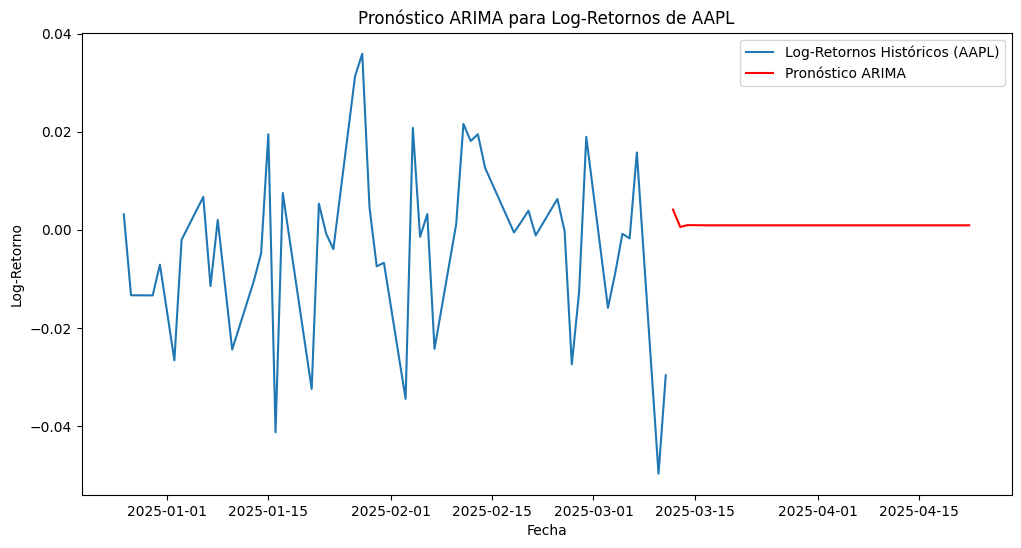

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-5193.291, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-5203.532, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-5202.317, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-5205.298, Time=0.21 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-5204.412, Time=0.27 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-5201.806, Time=0.28 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-5205.124, Time=0.55 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-5202.465, Time=0.43 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-5209.760, Time=0.57 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-5208.703, Time=0.30 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-5209.304, Time=0.76 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-5205.482, Time=1.35 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-5209.959, Time=3.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-5207.493, Time=0.59 sec
 ARIMA(1,0,2)(0,0,0

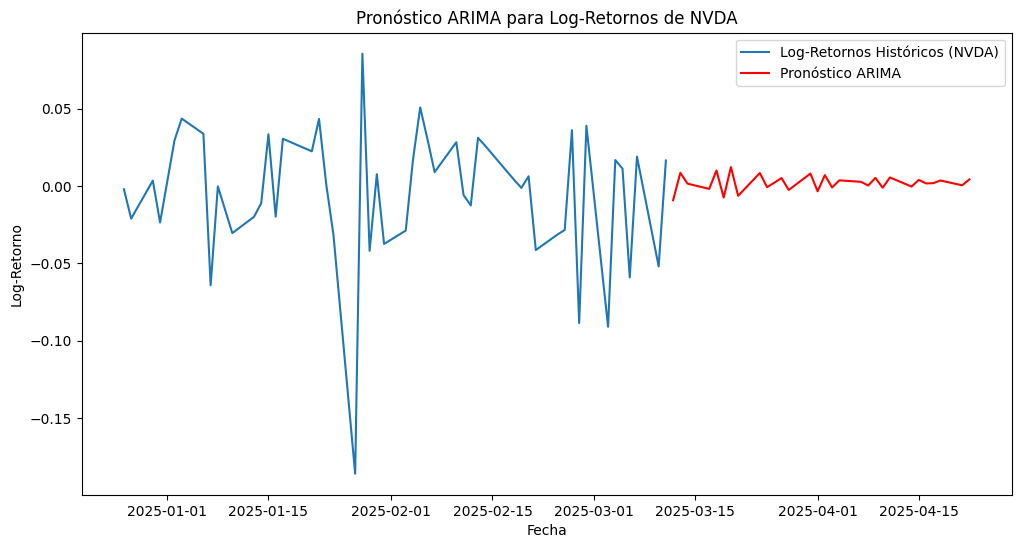

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-6736.799, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-6775.408, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-6774.640, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-6773.425, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-6773.427, Time=0.54 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-6771.436, Time=2.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-6776.200, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-6736.754, Time=0.38 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-6774.245, Time=0.44 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-6774.253, Time=1.21 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-6775.605, Time=0.57 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-6772.243, Time=1.31 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 7.182 seconds

MSFT - Mejor orden ARIMA: (1, 0, 0)


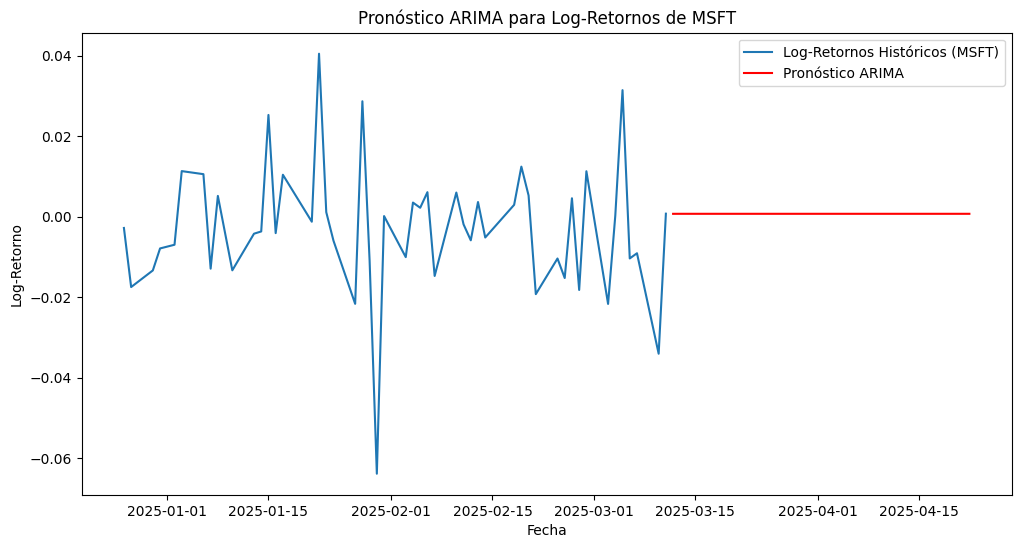

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-5747.087, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-5746.311, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-5746.285, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-5744.319, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-5745.189, Time=0.25 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.832 seconds

F - Mejor orden ARIMA: (0, 0, 0)


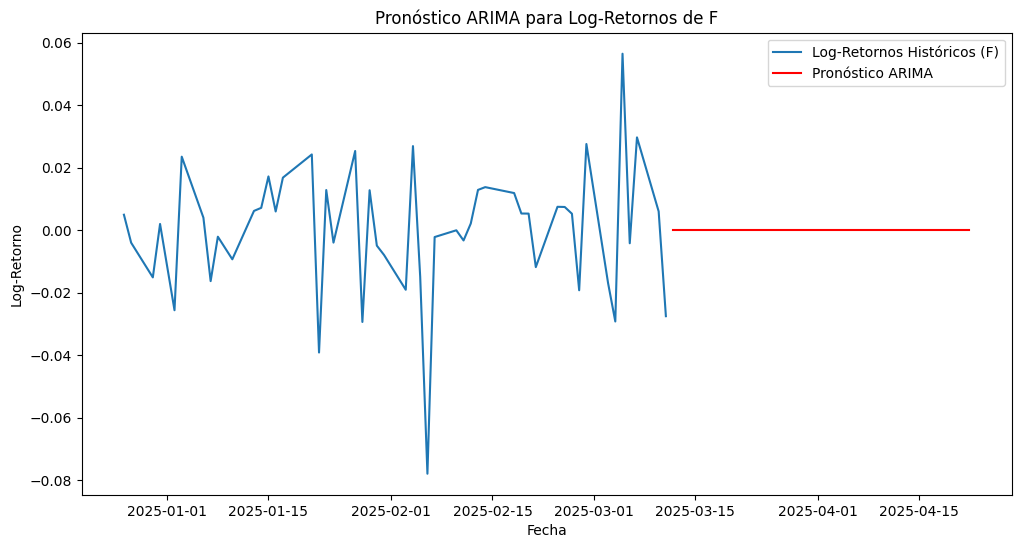

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-6309.314, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-6308.682, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-6308.642, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-6307.413, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-6308.235, Time=0.25 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.694 seconds

AMZN - Mejor orden ARIMA: (0, 0, 0)


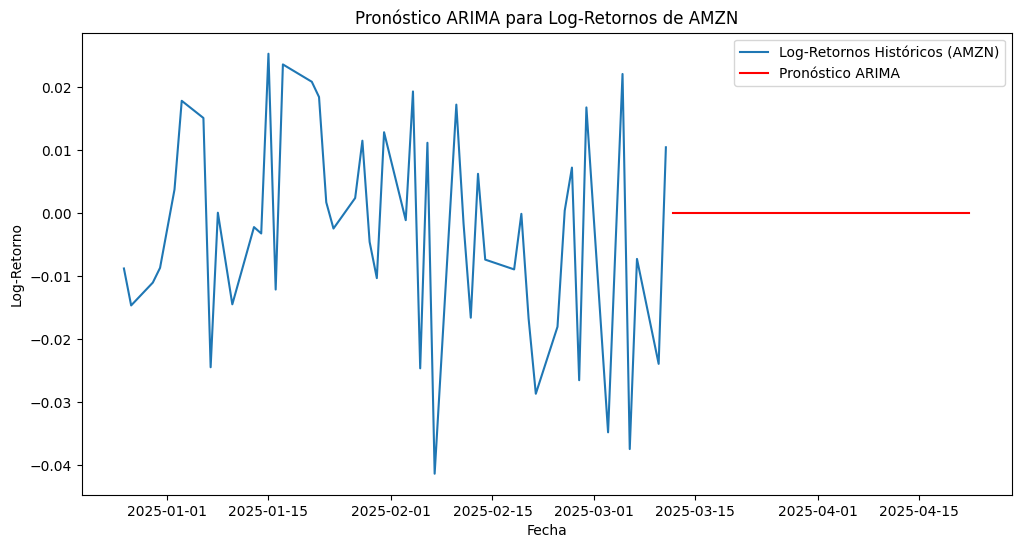

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-4634.457, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-4632.521, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-4632.508, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-4634.671, Time=0.54 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-4634.509, Time=0.48 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-4633.650, Time=0.26 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-4633.395, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-4633.461, Time=0.22 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-4638.474, Time=1.12 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-4634.019, Time=1.29 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-4635.573, Time=3.55 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-4632.150, Time=0.55 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-4631.744, Time=0.24 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-4634.414, Time=1.61 sec
 ARIMA(2,0,2)(0,0,0

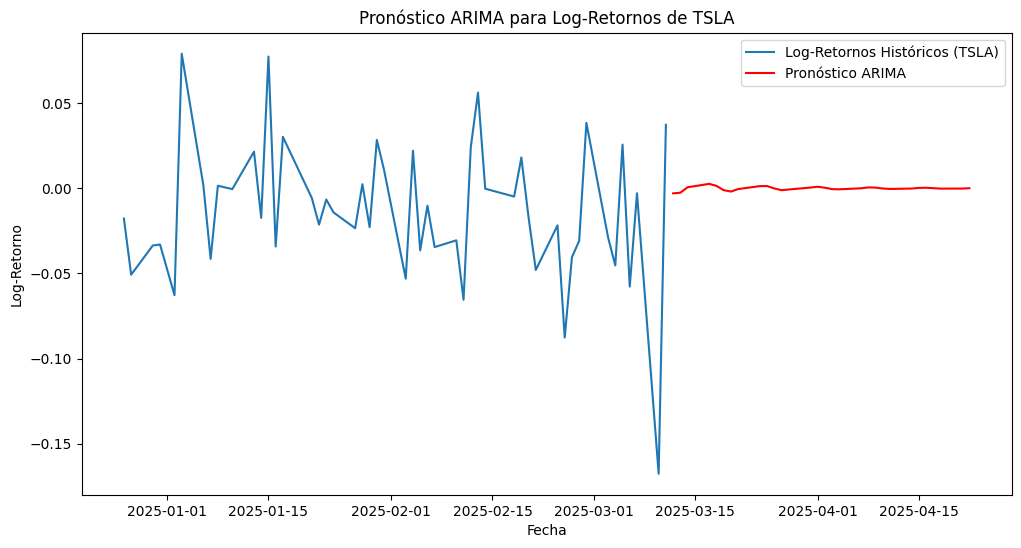

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-6469.817, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-6484.467, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-6482.907, Time=0.23 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-6485.144, Time=0.19 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-6483.160, Time=0.49 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-6483.131, Time=0.36 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-6484.396, Time=0.59 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-6481.141, Time=0.48 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-6483.281, Time=0.63 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 3.164 seconds

SBUX - Mejor orden ARIMA: (2, 0, 0)


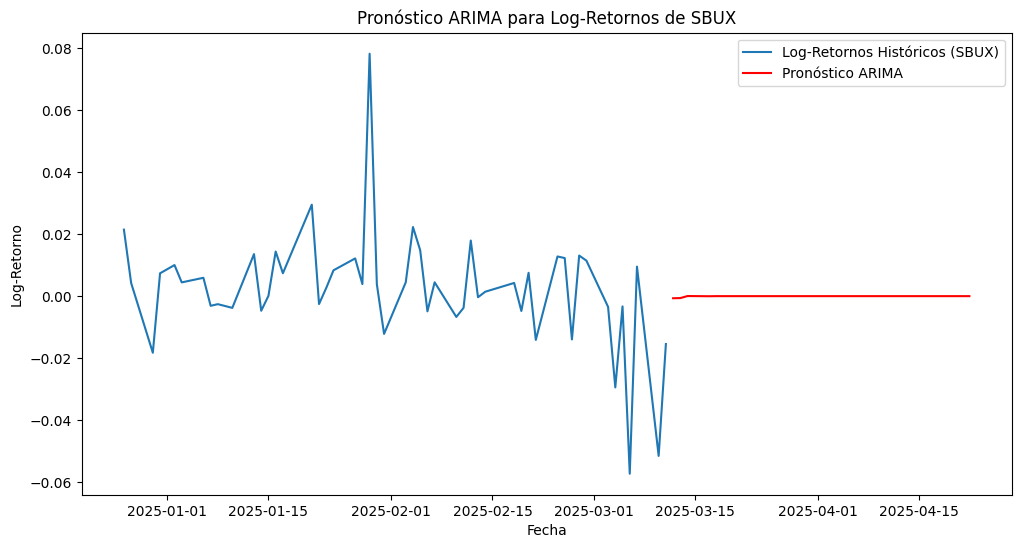

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-6367.793, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-6366.011, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-6366.003, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-6364.007, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-6365.838, Time=0.28 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.901 seconds

NKE - Mejor orden ARIMA: (0, 0, 0)


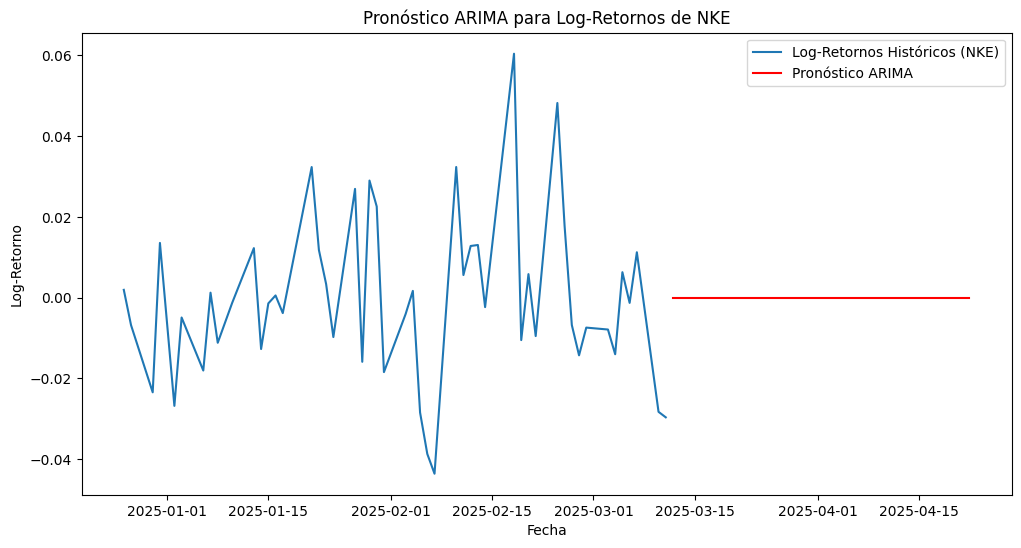

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-6557.287, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-6565.211, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-6564.898, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-6563.536, Time=0.27 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-6563.802, Time=0.31 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-6561.478, Time=2.23 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-6565.084, Time=0.22 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 3.330 seconds

GOOGL - Mejor orden ARIMA: (1, 0, 0)


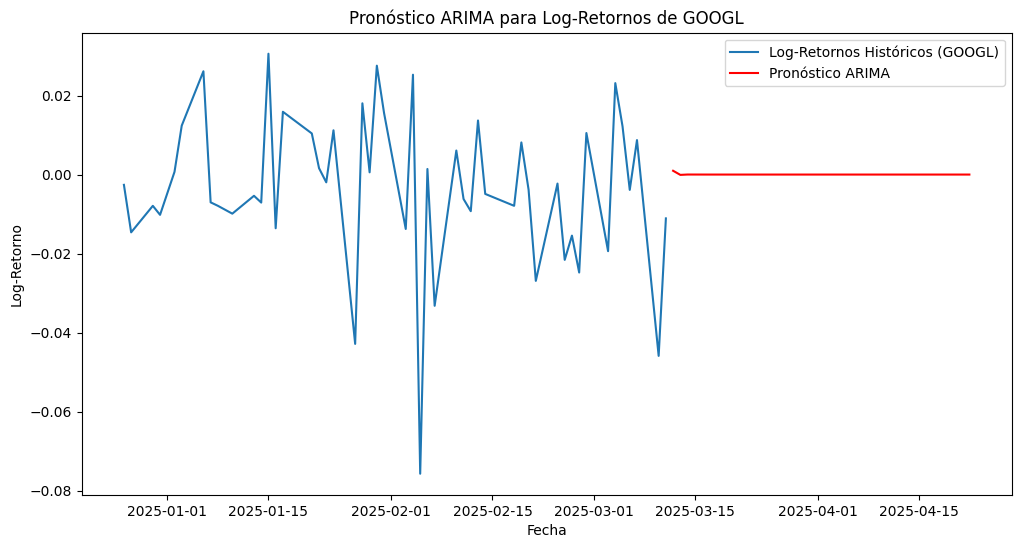

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-6583.699, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-6602.898, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-6599.139, Time=0.26 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-6613.971, Time=0.23 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-6611.971, Time=0.31 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-6611.971, Time=0.42 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-6603.719, Time=0.28 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-6610.006, Time=0.63 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-6612.927, Time=0.24 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 2.679 seconds

JPM - Mejor orden ARIMA: (2, 0, 0)


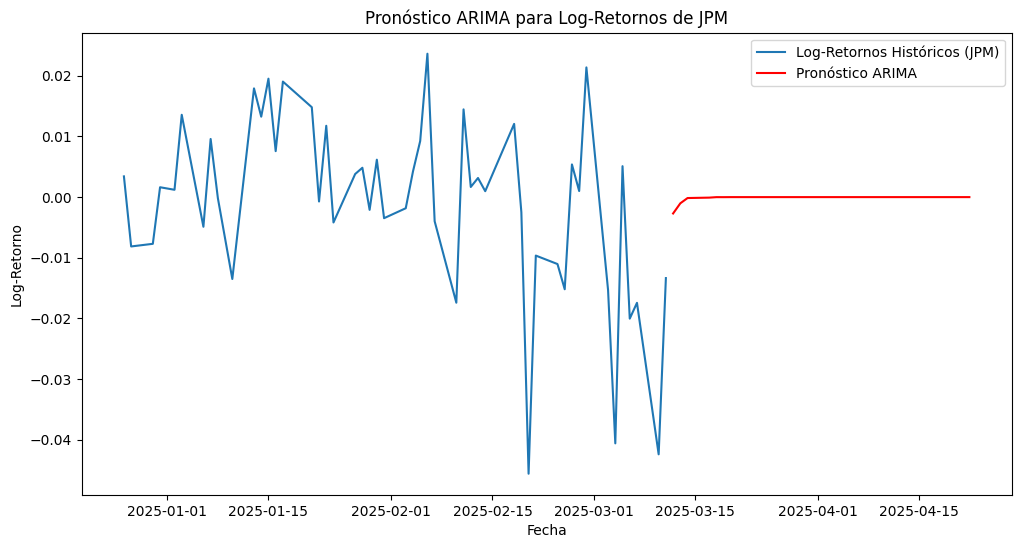

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-7109.577, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-7108.315, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-7108.304, Time=0.20 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-7106.309, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-7107.864, Time=0.24 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.970 seconds

LMT - Mejor orden ARIMA: (0, 0, 0)


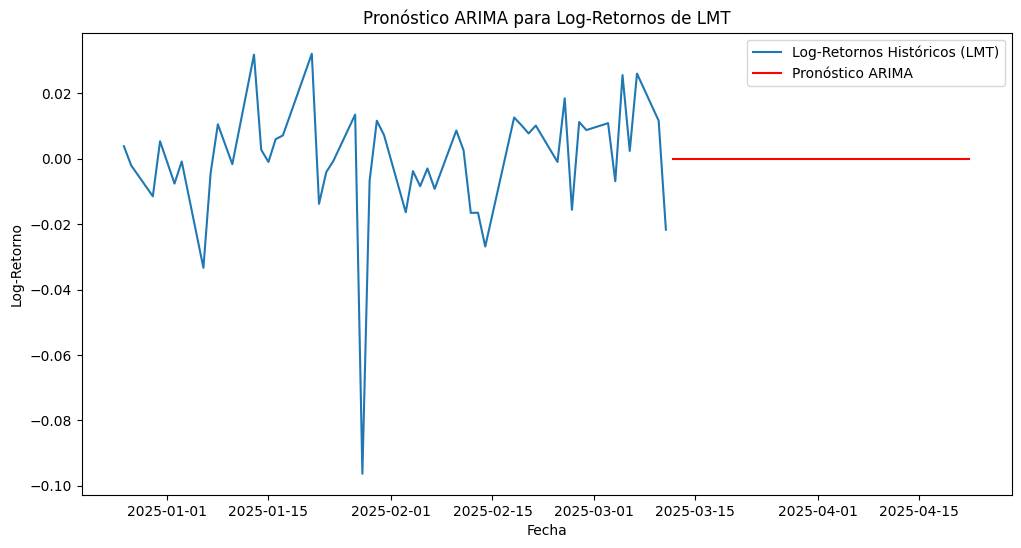

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-6436.899, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-6437.547, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-6437.517, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-6435.591, Time=0.24 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-6435.617, Time=0.21 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-6433.584, Time=0.40 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-6435.579, Time=0.32 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 1.534 seconds

HII - Mejor orden ARIMA: (1, 0, 0)


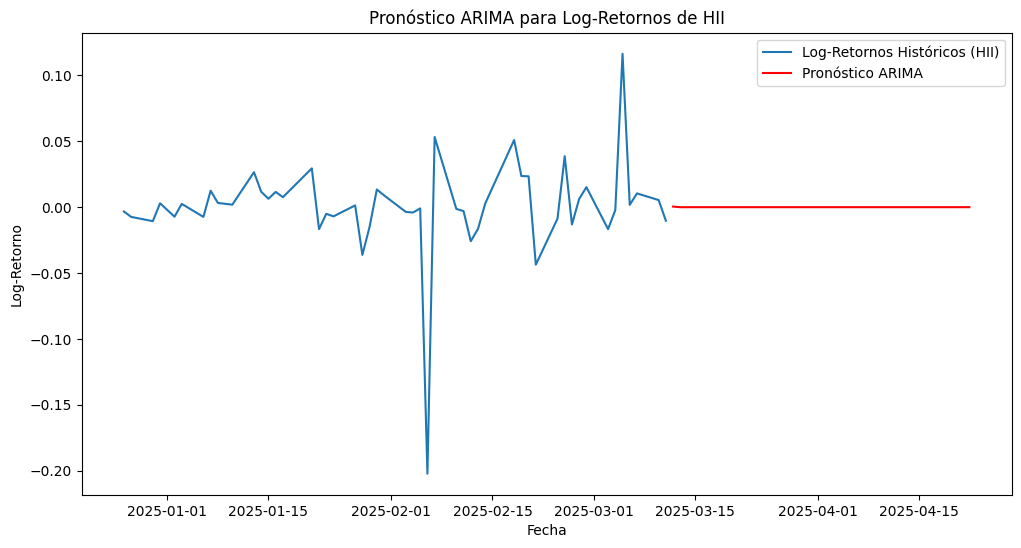

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-5422.159, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-5424.112, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-5423.669, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-5427.409, Time=0.29 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-5426.576, Time=0.30 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-5424.460, Time=0.24 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-5425.644, Time=0.57 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-5424.660, Time=0.36 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-5425.582, Time=0.61 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 2.851 seconds

KTOS - Mejor orden ARIMA: (2, 0, 0)


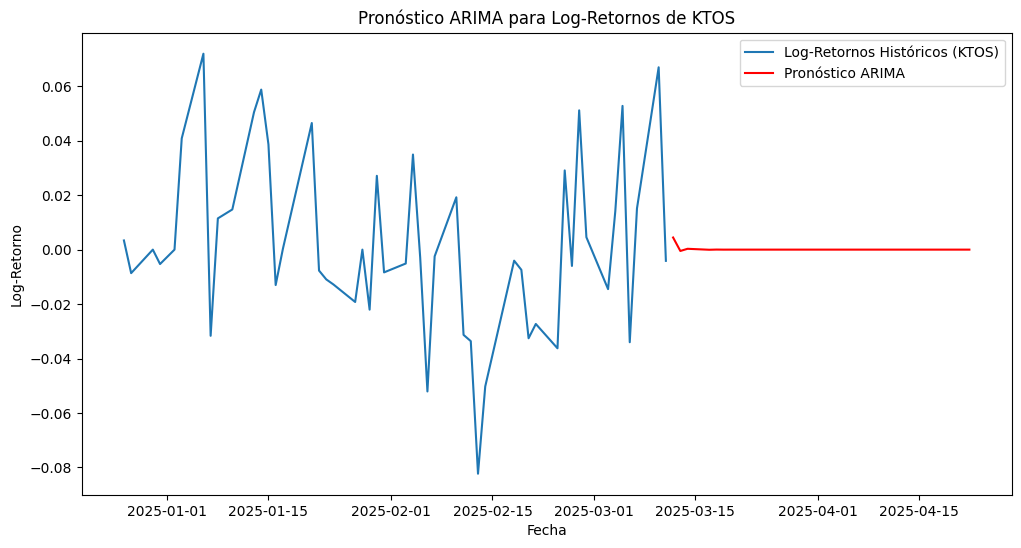

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-6656.280, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-6659.778, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-6659.427, Time=0.40 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-6659.253, Time=0.40 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-6658.914, Time=2.16 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-6669.046, Time=1.48 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-6655.882, Time=0.44 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-6701.639, Time=1.16 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-6666.868, Time=0.75 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-6655.833, Time=1.37 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-6655.107, Time=1.48 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-6656.633, Time=0.79 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-6653.673, Time=1.51 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-6664.117, Time=2.07 sec

Best model:  ARIMA

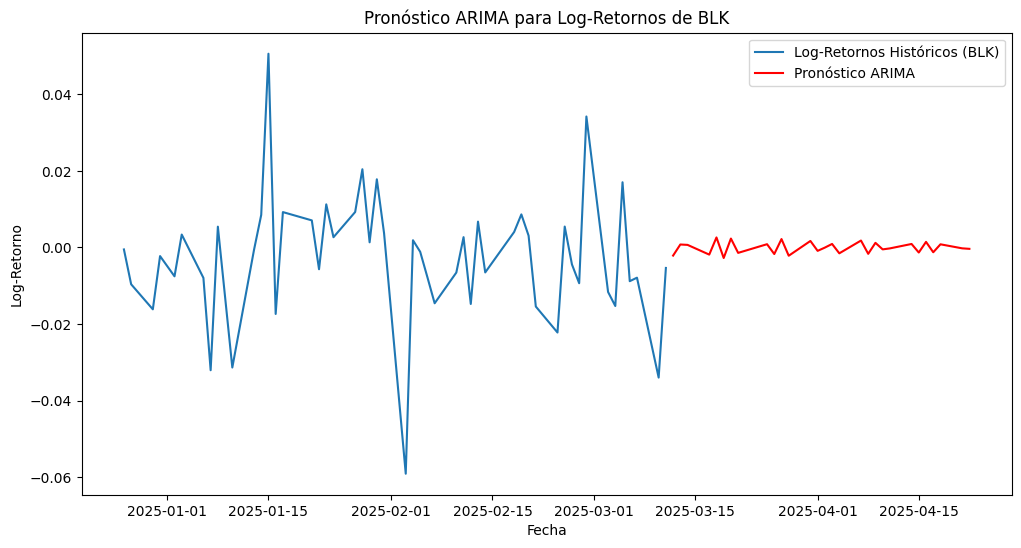

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
from pmdarima import auto_arima
import matplotlib.pyplot as plt

# Definir las 14 acciones
tickers = ['AAPL', 'NVDA', 'MSFT', 'F', 'AMZN', 'TSLA', 'SBUX', 'NKE', 'GOOGL', 'JPM', 'LMT', 'HII', 'KTOS', 'BLK']

# Descargar datos
data = yf.download(tickers, start='2019-11-29', end='2025-03-12', interval='1d')['Close']
log_returns = np.log(data / data.shift(1)).dropna()

# Optimización de ARIMA para cada acción
for ticker in tickers:
    series = log_returns[ticker].dropna()
    model = auto_arima(series, start_p=0, start_q=0, max_p=5, max_q=5, d=0,
                       seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
    print(f"\n{ticker} - Mejor orden ARIMA: {model.order}")

    # Pronóstico a 30 días
    forecast = model.predict(n_periods=30)

    # Visualización
    plt.figure(figsize=(12, 6))
    plt.plot(series.tail(50), label=f'Log-Retornos Históricos ({ticker})')
    plt.plot(pd.date_range(start=series.index[-1], periods=31, freq='B')[1:],
             forecast, label='Pronóstico ARIMA', color='red')
    plt.title(f'Pronóstico ARIMA para Log-Retornos de {ticker}')
    plt.xlabel('Fecha')
    plt.ylabel('Log-Retorno')
    plt.legend()
    plt.show()

In [ ]:
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import coint

# Descargar datos
tickers = ['AAPL', 'NVDA', 'MSFT', 'F', 'AMZN', 'TSLA', 'SBUX', 'NKE', 'GOOGL', 'JPM', 'LMT', 'HII', 'KTOS', 'BLK']
data = yf.download(tickers, start='2019-11-29', end='2025-03-12', interval='1d')['Close']

# Pruebas de cointegración con AAPL como referencia
for ticker in tickers[1:]:  # Excluir AAPL
    result = coint(data['AAPL'], data[ticker])
    print(f"\nCointegración AAPL vs {ticker}: p-value = {result[1]:.4f}")

[*********************100%***********************]  14 of 14 completed



Cointegración AAPL vs NVDA: p-value = 0.1815

Cointegración AAPL vs MSFT: p-value = 0.3646

Cointegración AAPL vs F: p-value = 0.7952

Cointegración AAPL vs AMZN: p-value = 0.7734

Cointegración AAPL vs TSLA: p-value = 0.8174

Cointegración AAPL vs SBUX: p-value = 0.7472

Cointegración AAPL vs NKE: p-value = 0.5437

Cointegración AAPL vs GOOGL: p-value = 0.2258

Cointegración AAPL vs JPM: p-value = 0.1045

Cointegración AAPL vs LMT: p-value = 0.1389

Cointegración AAPL vs HII: p-value = 0.5042

Cointegración AAPL vs KTOS: p-value = 0.6507

Cointegración AAPL vs BLK: p-value = 0.4392


[*********************100%***********************]  14 of 14 completed


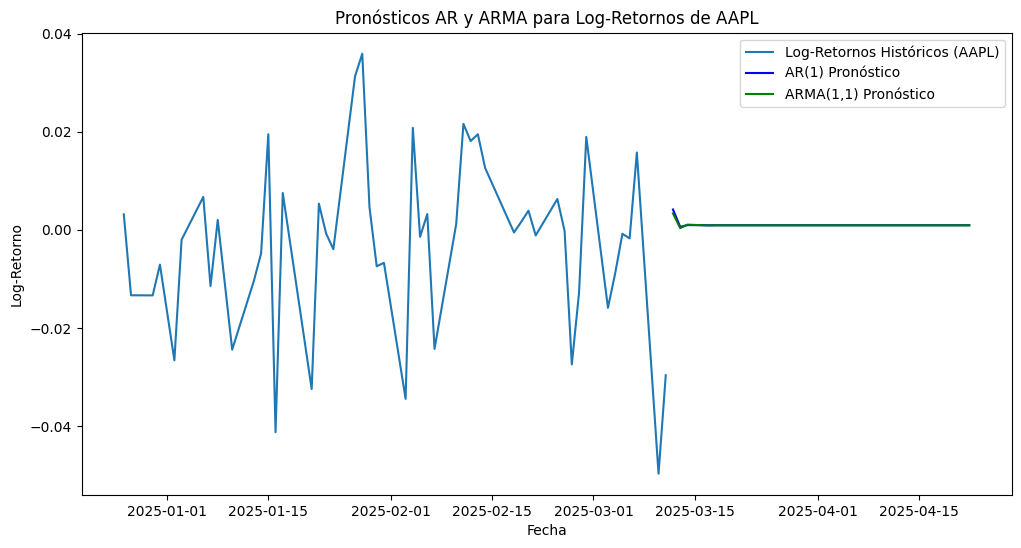

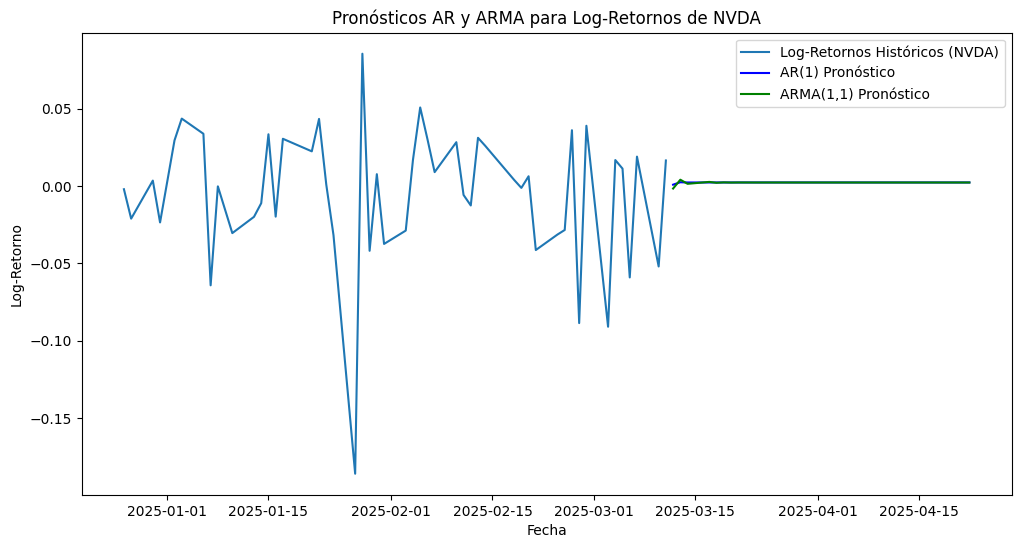

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Descargar datos
data = yf.download(tickers, start='2019-11-29', end='2025-03-12', interval='1d')['Close']
log_returns = np.log(data / data.shift(1)).dropna()

# Modelos AR y ARMA para las primeras 2 acciones (puedes expandir)
for ticker in tickers[:2]:
    series = log_returns[ticker].dropna()

    # AR(1)
    ar_model = AutoReg(series, lags=1)
    ar_fit = ar_model.fit()
    ar_forecast = ar_fit.forecast(steps=30)

    # ARMA(1,1)
    arma_model = ARIMA(series, order=(1, 0, 1))
    arma_fit = arma_model.fit()
    arma_forecast = arma_fit.forecast(steps=30)

    # Visualización
    plt.figure(figsize=(12, 6))
    plt.plot(series.tail(50), label=f'Log-Retornos Históricos ({ticker})')
    plt.plot(pd.date_range(start=series.index[-1], periods=31, freq='B')[1:],
             ar_forecast, label='AR(1) Pronóstico', color='blue')
    plt.plot(pd.date_range(start=series.index[-1], periods=31, freq='B')[1:],
             arma_forecast, label='ARMA(1,1) Pronóstico', color='green')
    plt.title(f'Pronósticos AR y ARMA para Log-Retornos de {ticker}')
    plt.xlabel('Fecha')
    plt.ylabel('Log-Retorno')
    plt.legend()
    plt.show()

[*********************100%***********************]  3 of 3 completed


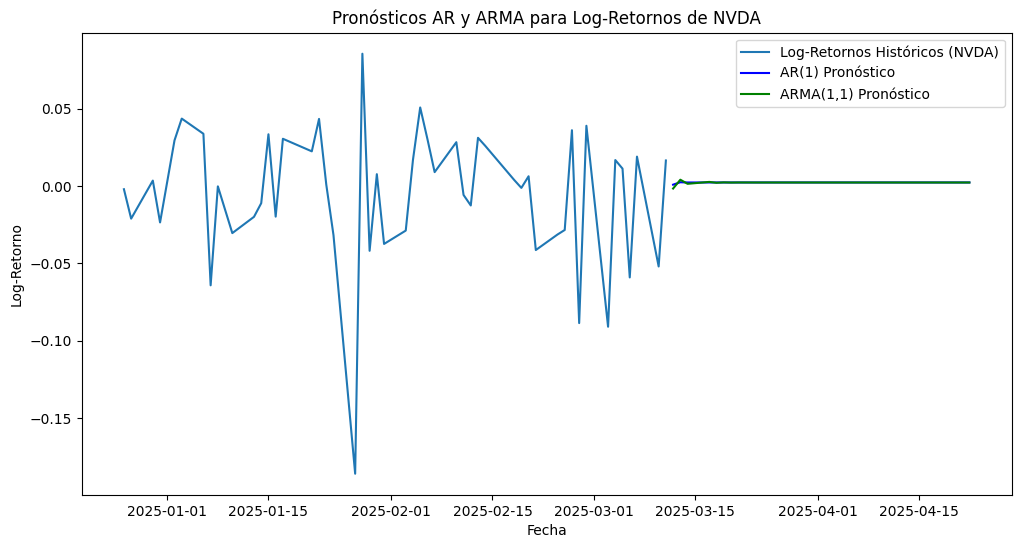

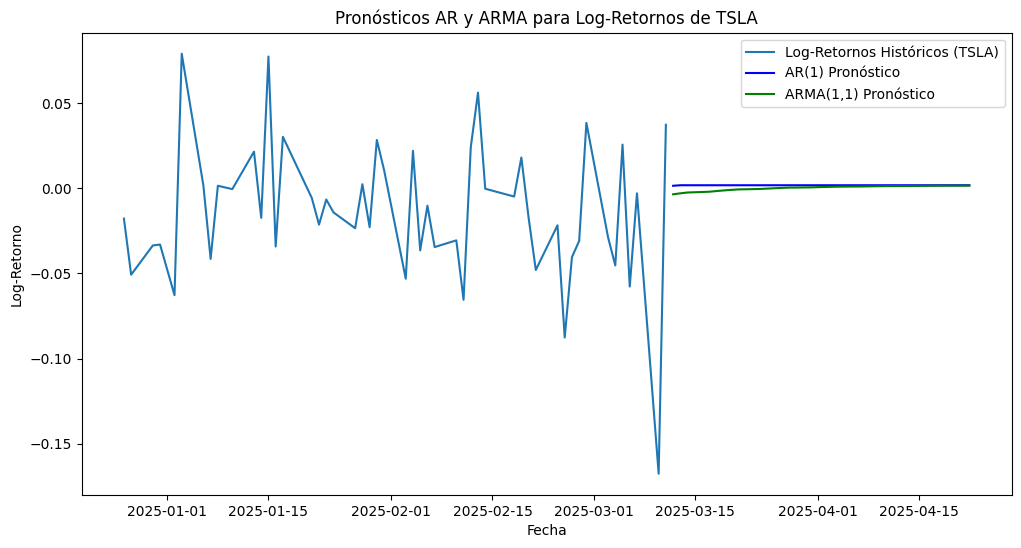

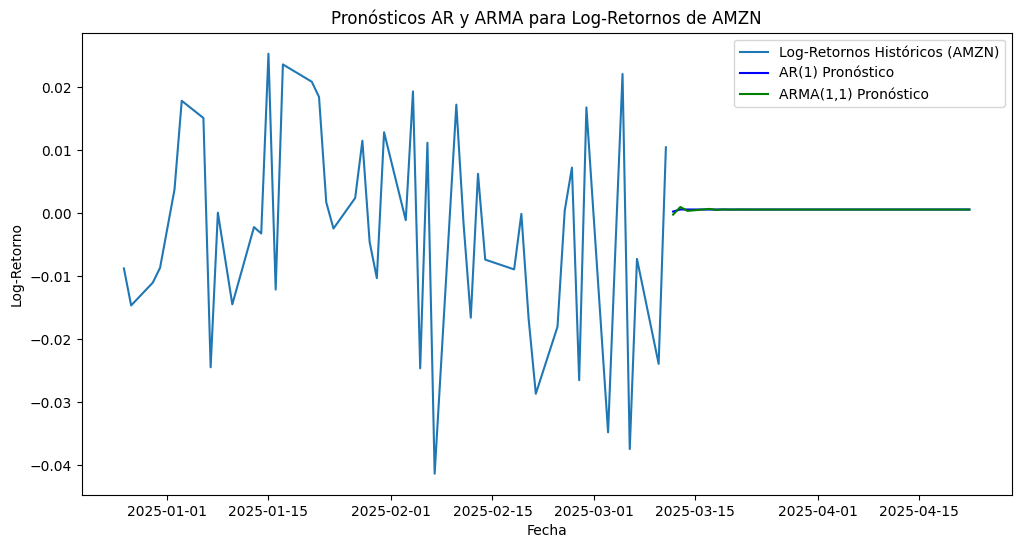

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Definir las acciones seleccionadas
tickers = ['NVDA', 'TSLA', 'AMZN']

# Descargar datos
data = yf.download(tickers, start='2019-11-29', end='2025-03-12', interval='1d')['Close']
log_returns = np.log(data / data.shift(1)).dropna()

# Modelos AR y ARMA
for ticker in tickers:
    series = log_returns[ticker].dropna()

    # AR(1)
    ar_model = AutoReg(series, lags=1)
    ar_fit = ar_model.fit()
    ar_forecast = ar_fit.forecast(steps=30)

    # ARMA(1,1)
    arma_model = ARIMA(series, order=(1, 0, 1))
    arma_fit = arma_model.fit()
    arma_forecast = arma_fit.forecast(steps=30)

    # Visualización
    plt.figure(figsize=(12, 6))
    plt.plot(series.tail(50), label=f'Log-Retornos Históricos ({ticker})')
    plt.plot(pd.date_range(start=series.index[-1], periods=31, freq='B')[1:],
             ar_forecast, label='AR(1) Pronóstico', color='blue')
    plt.plot(pd.date_range(start=series.index[-1], periods=31, freq='B')[1:],
             arma_forecast, label='ARMA(1,1) Pronóstico', color='green')
    plt.title(f'Pronósticos AR y ARMA para Log-Retornos de {ticker}')
    plt.xlabel('Fecha')
    plt.ylabel('Log-Retorno')
    plt.legend()
    plt.show()

[*********************100%***********************]  1 of 1 completed


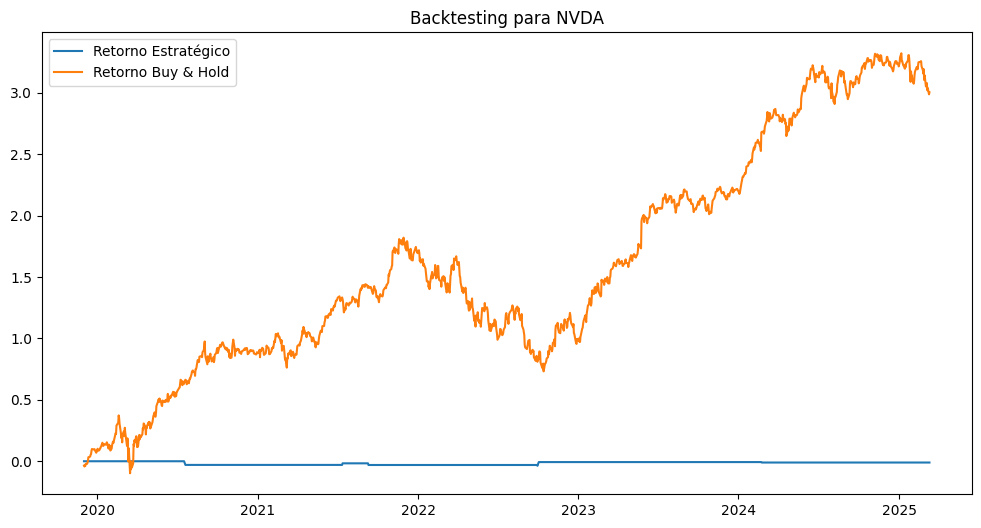

[*********************100%***********************]  1 of 1 completed


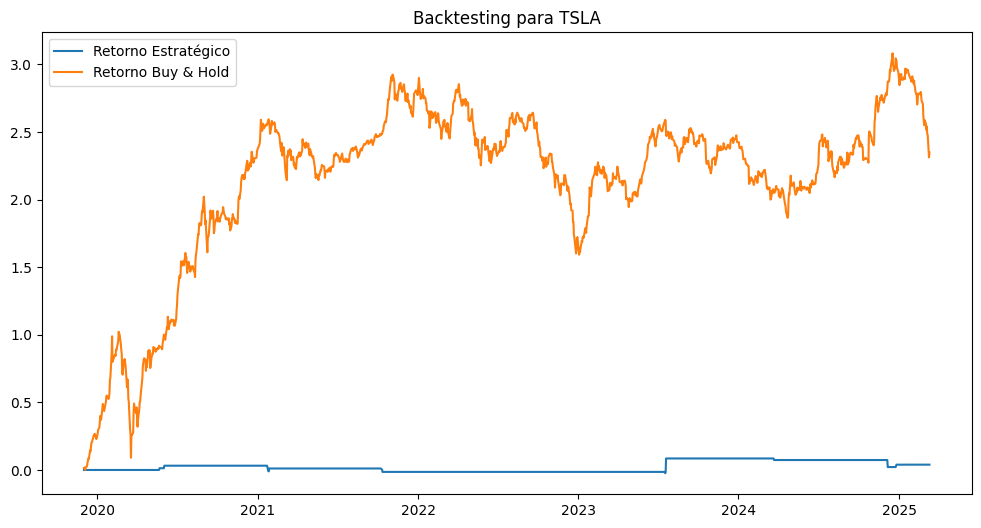

[*********************100%***********************]  1 of 1 completed


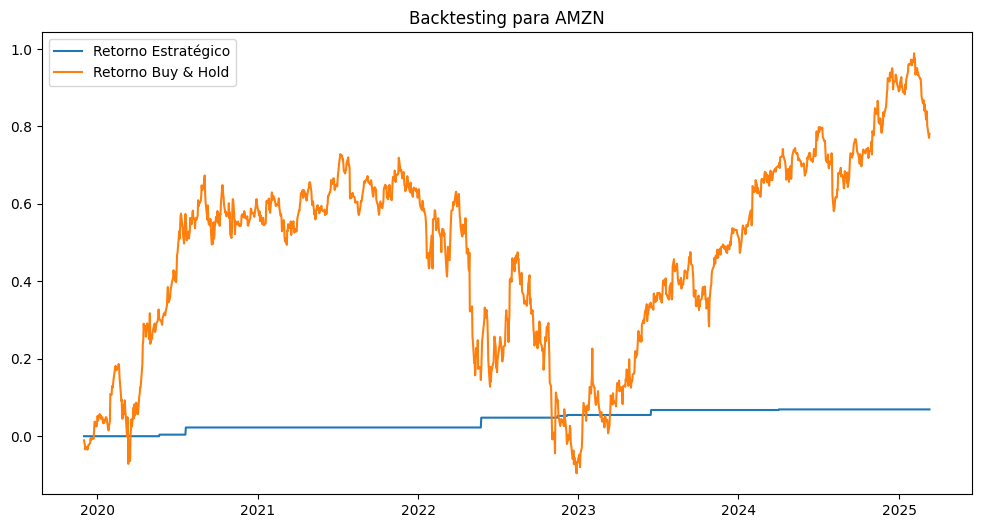

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

tickers = ['NVDA', 'TSLA', 'AMZN']
for ticker in tickers:
    data_full = yf.download(ticker, start='2019-11-29', end='2025-03-12', interval='1d')
    data_full['Log_Returns'] = np.log(data_full['Close'] / data_full['Close'].shift(1))
    exp1 = data_full['Close'].ewm(span=12).mean()
    exp2 = data_full['Close'].ewm(span=26).mean()
    data_full['MACD'] = exp1 - exp2
    data_full['Signal'] = data_full['MACD'].ewm(span=9).mean()
    delta = data_full['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data_full['RSI'] = 100 - (100 / (1 + rs))

    signals = pd.DataFrame(index=data_full.index)
    signals['Signal'] = 0
    signals.loc[(data_full['MACD'] > data_full['Signal']) & (data_full['RSI'] < 30), 'Signal'] = 1
    signals.loc[(data_full['MACD'] < data_full['Signal']) & (data_full['RSI'] > 70), 'Signal'] = -1
    signals['Returns'] = data_full['Log_Returns']
    signals['Strategy'] = signals['Signal'].shift(1) * signals['Returns']

    plt.figure(figsize=(12, 6))
    plt.plot(signals['Strategy'].cumsum(), label='Retorno Estratégico')
    plt.plot(signals['Returns'].cumsum(), label='Retorno Buy & Hold')
    plt.title(f'Backtesting para {ticker}')
    plt.legend()
    plt.show()

In [ ]:
!pip install nbconvert

In [ ]:
from google.colab import drive
import os

# 1. Montar Google Drive
drive.mount('/content/drive')

# 2. Definir la ruta del archivo
input_path = "/content/drive/My Drive/6to semestre: feb-jun 2025/series de tiempo/Evidencia.ipynb"
output_path = "/content/drive/My Drive/6to semestre: feb-jun 2025/series de tiempo/Evidencia.html"

# 3. Convertir a HTML usando nbconvert
!jupyter nbconvert --to html "$input_path" --output "$output_path"

print(f"Archivo convertido y guardado en: {output_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[NbConvertApp] Converting notebook /content/drive/My Drive/6to semestre: feb-jun 2025/series de tiempo/Evidencia.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 40 image(s).
[NbConvertApp] Writing 3522774 bytes to /content/drive/My Drive/6to semestre: feb-jun 2025/series de tiempo/Evidencia.html
Archivo convertido y guardado en: /content/drive/My Drive/6to semestre: feb-jun 2025/series de tiempo/Evidencia.html
